In [ ]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

import pickle

from qubic.lib.MapMaking.Qatmosphere_2d import AtmosphereMaps

import yaml

In [2]:
# Import simulation parameters
with open('params.yml', 'r') as file:
    params = yaml.safe_load(file) 
    
# Call the class which build the atmosphere maps
atm = AtmosphereMaps(params)

In [3]:
kx, ky, knorm = atm.get_fourier_grid_2d(params['n_grid'], params['size_atm'])

In [4]:
water_vapor_fluctuations_fourier = atm.get_water_vapor_density_2d_map(0, angular=False)
water_vapor_fluctuations_sph = atm.get_water_vapor_density_2d_map(0, angular=True)

Text(0, 0.5, 'y (m)')

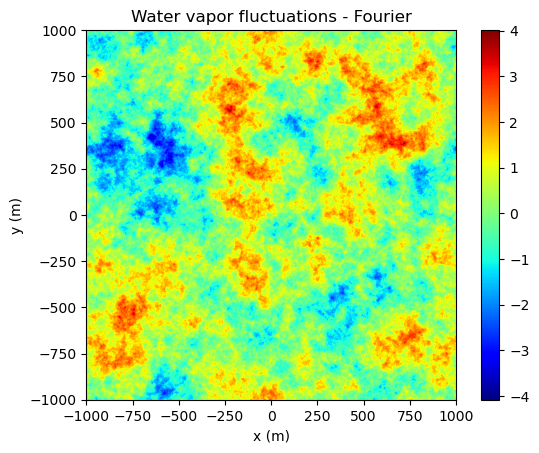

In [5]:
plt.imshow(water_vapor_fluctuations_fourier, cmap='jet', extent=[-params['size_atm'], params['size_atm'], -params['size_atm'], params['size_atm']])
plt.colorbar()
plt.title('Water vapor fluctuations - Fourier')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

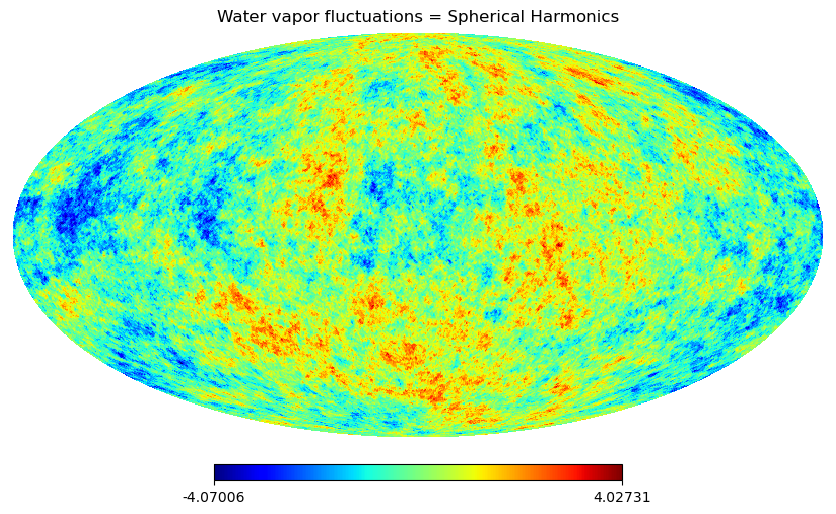

In [6]:
hp.mollview(water_vapor_fluctuations_sph, cmap='jet', title='Water vapor fluctuations = Spherical Harmonics')

In [7]:
theta, phi = hp.pix2ang(params['nside'], np.arange(hp.nside2npix(params['nside'])))

In [8]:
def azel_to_cart(theta, phi, r):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

def cart_to_azel(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z/r)
    phi = np.arctan2(y, x)
    return theta, phi

In [9]:
atm_altitude = params['altitude_atm_2d']
x, y = np.meshgrid(np.linspace(-params['size_atm'], params['size_atm'], params['n_grid']), np.linspace(-params['size_atm'], params['size_atm'], params['n_grid']))

theta_fourier, phi_fourier = cart_to_azel(x, y, atm_altitude)

In [10]:
test_sph = np.zeros(water_vapor_fluctuations_sph.shape[0])
test_square = np.zeros(water_vapor_fluctuations_fourier.shape[0])

idx = hp.ang2pix(params['nside'], theta_fourier, phi_fourier)

test_sph[idx.ravel()] = water_vapor_fluctuations_sph[idx.ravel()]
test_square = np.reshape(water_vapor_fluctuations_sph[idx.ravel()], water_vapor_fluctuations_fourier.shape)

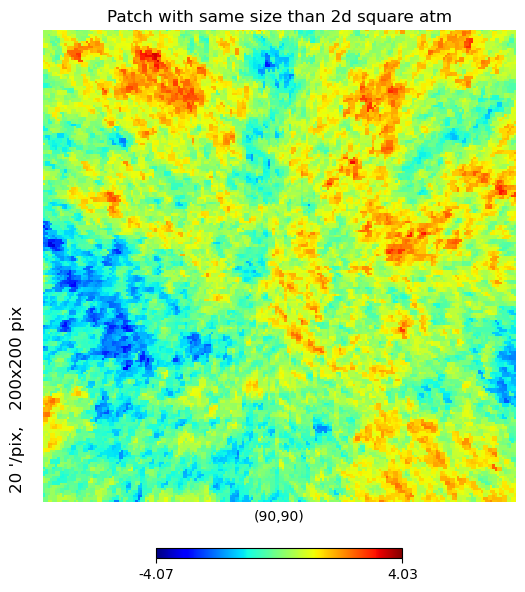

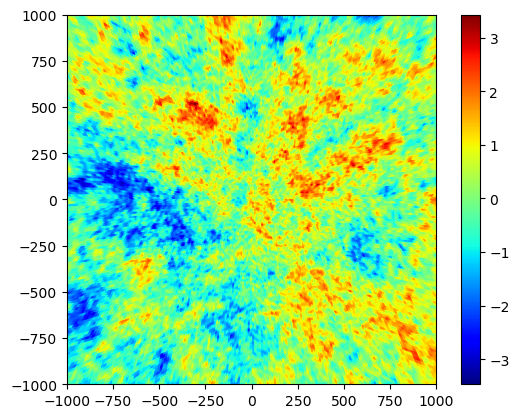

In [11]:
hp.gnomview(test_sph, cmap='jet', rot=(90,90,0),reso=20,min=np.min(water_vapor_fluctuations_sph), max=np.max(water_vapor_fluctuations_sph), title='Patch with same size than 2d square atm')

plt.figure()
plt.imshow(test_square, cmap='jet', extent=[-params['size_atm'], params['size_atm'], -params['size_atm'], params['size_atm']])
plt.colorbar()

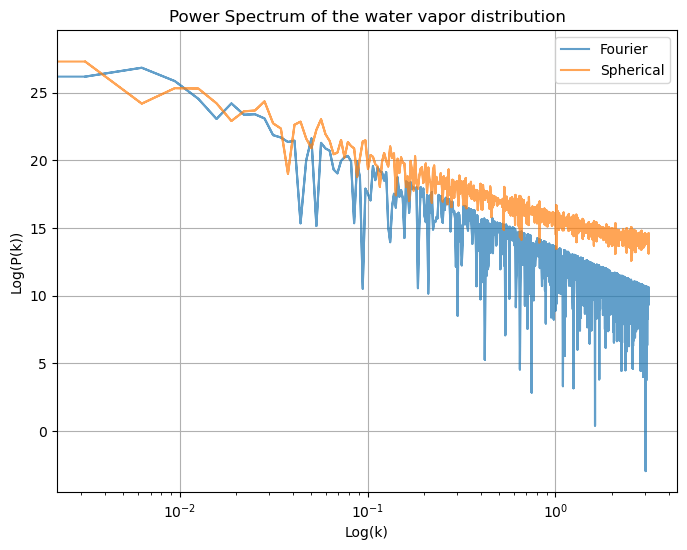

In [12]:
fft_fourier = np.fft.fft2(water_vapor_fluctuations_fourier)
fft_sph = np.fft.fft2(test_square)

power_spectrum_fourier = np.abs(fft_fourier)**2
power_spectrum_sph = np.abs(fft_sph)**2

power_spectrum_flat_fourier = power_spectrum_fourier[0]
power_spectrum_flat_sph = power_spectrum_sph[0]

# Compute the logarithm of the power spectrum
log_power_spectrum_fourier = np.log(power_spectrum_flat_fourier)
log_power_spectrum_sph = np.log(power_spectrum_flat_sph)

# Plot the power spectrum and the fit
plt.figure(figsize=(8, 6))
plt.plot((knorm[0]), log_power_spectrum_fourier, label='Fourier', alpha=0.7)
plt.plot((knorm[0]), log_power_spectrum_sph, label='Spherical', alpha=0.7)
plt.ylabel('Log(P(k))')
plt.xlabel('Log(k)')
plt.title('Power Spectrum of the water vapor distribution')
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.show()

In [13]:
from qubic.lib.Calibration.Qfiber import profile
nbins = 1000

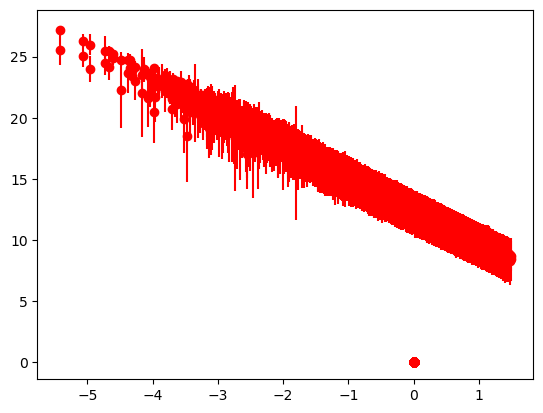

In [14]:
fft_fourier = np.fft.fft2(water_vapor_fluctuations_fourier)
fft_sph = np.fft.fft2(test_square)

power_spectrum_fourier = np.abs(fft_fourier)**2
power_spectrum_sph = np.abs(fft_sph)**2

power_spectrum_flat_fourier = power_spectrum_fourier.ravel()
power_spectrum_flat_sph = power_spectrum_sph.ravel()

# Compute the logarithm of the power spectrum
log_power_spectrum_fourier = np.log(power_spectrum_flat_fourier)
log_power_spectrum_sph = np.log(power_spectrum_flat_sph)

xx_fourier, yy_fourier, dx_fourier, dy_fourier, others_fourier = profile(np.log(knorm.ravel()), log_power_spectrum_fourier, nbins=nbins)
xx_sph, yy_sph, dx_sph, dy_sph, others_sph = profile(np.log(knorm.ravel()), log_power_spectrum_sph, nbins=nbins)

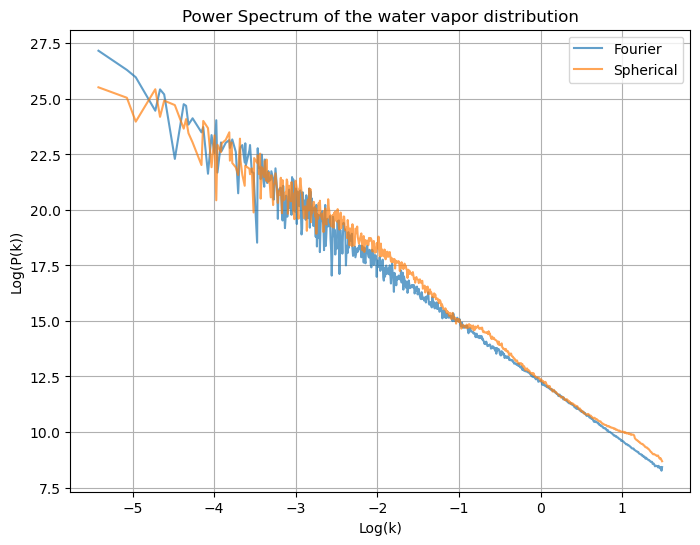

In [15]:
# Plot the power spectrum and the fit
plt.figure(figsize=(8, 6))
plt.plot(xx_fourier, yy_fourier, label='Fourier', alpha=0.7)
plt.plot(xx_sph, yy_sph, label='Spherical', alpha=0.7)
plt.ylabel('Log(P(k))')
plt.xlabel('Log(k)')
plt.title('Power Spectrum of the water vapor distribution')
plt.legend()
plt.grid(True)
plt.show()

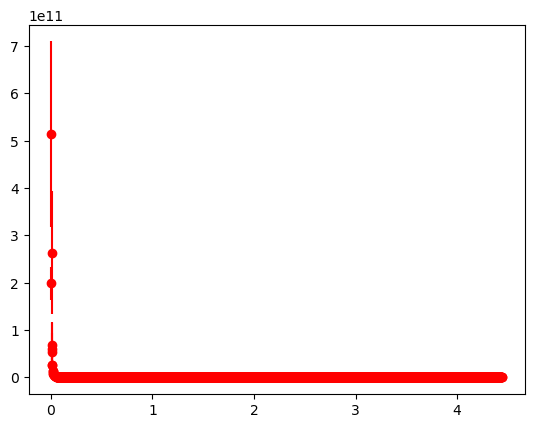

In [16]:
xc_fourier, yval_fourier, dx_fourier, dy_fourier, others_fourier = profile(knorm.ravel(), power_spectrum_fourier.ravel(), nbins=nbins)
xc_sph, yval_sph, dx_sph, dy_sph, others_sph = profile(knorm.ravel(), power_spectrum_sph.ravel(), nbins=nbins)

# kolmogorov = atm.normalized_kolmogorov_spectrum_2d(knorm, params['correlation_length'])
# xc_kolmogorov, yval_kolmogorov, dx_kolmogorov, dy_kolmogorov, others_kolmogorov = profile(knorm.ravel(), kolmogorov.ravel(), nbins=nbins)

In [17]:
from scipy.stats import linregress
res_fourier = linregress(np.log(xc_fourier), np.log(yval_fourier))
res_sph = linregress(np.log(xc_sph), np.log(yval_sph))
#res_kolmogorov = linregress(np.log(xc_kolmogorov), np.log(yval_kolmogorov))

slope_fourier, intercept_fourier = res_fourier.slope, res_fourier.intercept
slope_sph, intercept_sph = res_sph.slope, res_sph.intercept
#slope_kolmogorov, intercept_kolmogorov = res_kolmogorov.slope, res_kolmogorov.intercept

In [18]:
print('-8/3', -8/3)
print('Fourier', slope_fourier)
print('Spherical', slope_sph)
#print('Kolmogorov', slope_kolmogorov)

-8/3 -2.6666666666666665
Fourier -2.6422753365766716
Spherical -2.593566887679401


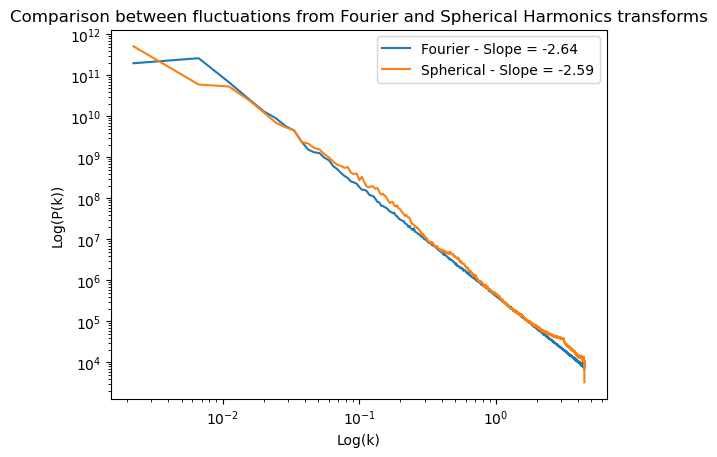

In [19]:
plt.plot(xc_fourier, yval_fourier, label=f'Fourier - Slope = {slope_fourier:.2f}')
plt.plot(xc_sph, yval_sph, label=f'Spherical - Slope = {slope_sph:.2f}')
# plt.plot(xc_kolmogorov, yval_kolmogorov, label=f'Kolmogorov - Slope = {slope_kolmogorov:.2f}')
plt.legend()
plt.title('Comparison between fluctuations from Fourier and Spherical Harmonics transforms')
plt.xlabel('Log(k)')
plt.ylabel('Log(P(k))')
plt.xscale('log')
plt.yscale('log')